In [29]:
import os
from tqdm import tqdm
import import_ipynb

from PIL import Image
import numpy as np

import matplotlib.pyplot as plt

import torch
from torchvision.transforms.functional import to_tensor, to_pil_image

from source.all_models import Generator #,Discriminator

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
torch.cuda.empty_cache()

In [31]:
def load_image(image_path, size = (512,512), resize = True ):

    img = Image.open(image_path).convert("RGB")

    # resizing the image if resize is true
    if resize == True:
        img = img.resize(size)

    return img

In [32]:
net = Generator().to(device)

path1 = '../animegan2-pytorch/weights/paprika.pt'
path2 = './weights/paprika_new.pt'

net.load_state_dict(torch.load(path2, map_location=device))
net.to(device).eval()

Generator(
  (block_a): Sequential(
    (0): ConvNormAct(
      (conv_norm_act_layer): Sequential(
        (0): ReflectionPad2d((3, 3, 3, 3))
        (1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), bias=False)
        (2): GroupNorm(1, 32, eps=1e-05, affine=True)
        (3): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (1): ConvNormAct(
      (conv_norm_act_layer): Sequential(
        (0): ReflectionPad2d((0, 1, 0, 1))
        (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (2): GroupNorm(1, 64, eps=1e-05, affine=True)
        (3): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (2): ConvNormAct(
      (conv_norm_act_layer): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): GroupNorm(1, 64, eps=1e-05, affine=True)
        (3): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
  )
  (block_b): Sequential(
    (0): ConvNormA

In [33]:
def test(args):

    # getting the device
    device = args['device']

    # justing printing some stats like total weight in the model
    print(f"Total weights in the models : {sum([p.numel() for p in net.parameters()])*1e-6:.3f}M")
    
    # loading the model from a checkpoint
    print(f"model loaded: {args['checkpoint']}")
    
    # making a directory of the model output
    os.makedirs(args['output_dir'], exist_ok=True)

    # number of images in the final directory
    print(len( os.listdir(args['input_dir'])[:5] ) )

    for image_name in tqdm(os.listdir(args['input_dir'])[:5]):

        if os.path.splitext(image_name)[-1].lower() not in [".jpg", ".png", ".bmp", ".tiff", ".jfif"]:
            print(os.path.splitext(image_name)[-1] , 'is not a valid file extension')
            continue
            
        image = load_image( os.path.join(args['input_dir'], image_name), args['size'], args['resize'] )

        with torch.no_grad():

            # loading image and making it like a tanh output
            image = to_tensor(image).unsqueeze(0)*2 - 1

            # print(image.max(), image.min())
            
            # getting the image output
            out = net( image.to(device), args['upsample_align'] ).cpu()

            # getting the output
            out = out.squeeze(0).clip(-1, 1) * 0.5 + 0.5

            # getting the PIL image
            out = to_pil_image(out).convert('RGB')

            plt.imshow(out)

        # saving the image
        out.save(os.path.join(args['output_dir'], image_name))
        print(f"image saved: {image_name}")


Total weights in the models : 2.144M
model loaded: ../animegan2-pytorch/weights/paprika.pt
5


 20%|██        | 1/5 [00:00<00:03,  1.24it/s]

image saved: 1.jpg


 40%|████      | 2/5 [00:01<00:01,  1.56it/s]

image saved: 2.jpg


 60%|██████    | 3/5 [00:01<00:01,  1.69it/s]

image saved: 3.jpg
.jpeg is not a valid file extension


100%|██████████| 5/5 [00:02<00:00,  2.08it/s]

image saved: actor 1.jpg


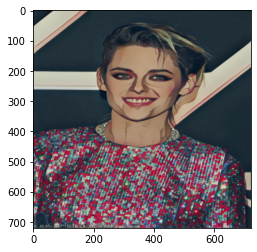

In [34]:
class my_dictionary(dict):
 
    # __init__ function
    def __init__(self):
        self = dict()
         
    # Function to add key:value
    def add(self, key, value):
        self[key] = value

args = my_dictionary()

args.add(
    'checkpoint','../animegan2-pytorch/weights/paprika.pt'
)
args.add(
    'input_dir', '../animegan2-pytorch/samples/inputs'
)
args.add(
    'output_dir', './samples/new_results'
)
args.add(
    'device','cuda:0'
)
args.add(
    'upsample_align',False
)
args.add(
    'size', (720,720)
)
args.add(
    'resize', True
)

test(args)
# args